## 对ID和OOD样本进行softmax可视化以及标准差分析
## 对比实验，利用softmax做异常检测  
reference：[A Baseline for Detecting Misclassified and Out-of-Distribution Examples in Neural Networks](https://arxiv.org/abs/1610.02136v1)  
github reference: https://github.com/hendrycks/error-detection  


In [1]:
# tensorflowGPU的设置
import tensorflow as tf

# tf.config.experimental.list_physical_devices('CPU')
gpus = tf.config.experimental.list_physical_devices('GPU')
# 在同时具有CPU和GPU的设备上，优先使用GPU运算, 实际中可以使用with tf.device创建设备上下文
# 例如： with tf.decice('/CPU:0'): 
# 限制内存增长
tf.config.experimental.set_memory_growth(gpus[0], True)

In [2]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from tensorflow import keras
from tensorflow.keras import Model
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
def pad_data(res, max_len=2850):
    length = len(res)
    if length > max_len:
        return res[ :max_len]
    elif length < max_len:
        return res + [0]*(max_len-length)
    return res


def train_data_generator(codes, labels, mode):
    
    if mode == 'train':    
        codes = codes[: 6000]
        labels = labels[: 6000]
    elif mode == 'val':    
        codes = codes[6000: ]
        labels = labels[6000: ]

    labels_res = np.eye(4)[labels]
    for idx in range(len(codes)):
        fn = codes[idx]
        fn = bytes.decode(fn)
        op_string = data_csv[data_csv.name == fn]
        if len(op_string) == 0:
            print('null')
            continue
        op_string = op_string.iloc[0, 1].split()
        res = list(le.transform(op_string))
        res = pad_data(res)
        yield res, labels_res[idx]
        
        
def train_data_loader(codes, labels, mode):
    
    if mode == 'train':    
        codes = codes[: 6000]
        labels = labels[: 6000]
    elif mode == 'val':    
        codes = codes[6000: ]
        labels = labels[6000: ]
    
    labels_res = np.eye(4)[labels]
    res_all = []
    for idx in tqdm(range(len(codes))):
        fn = codes[idx]
        op_string = data_csv[data_csv.name == fn]
        op_string = op_string.iloc[0, 1].split()
        res = list(le.transform(op_string))
        res = pad_data(res)
        res_all.append(res)
    return np.array(res_all), labels_res


def codes_loader(codes):
    
    res_all = []
    for idx in tqdm(range(len(codes))):
        fn = codes[idx]
        op_string = data_csv[data_csv.name == fn]
        op_string = op_string.iloc[0, 1].split()
        res = list(le.transform(op_string))
        res = pad_data(res)
        res_all.append(res)
    return np.array(res_all)


def codes_generator(codes):
    
    for idx in range(len(codes)):
        fn = codes[idx]
        fn = bytes.decode(fn)
        op_string = data_csv[data_csv.name == fn]
        if len(op_string) == 0:
            print('null')
            continue
        op_string = op_string.iloc[0, 1].split()
        res = list(le.transform(op_string))
        res = pad_data(res)
        yield res
        
        
def svmdata_generator(codes, labels, mode):
    
    if mode == 'train':    
        codes = codes[: 268]
        labels = labels[: 268]
    elif mode == 'val':    
        codes = codes[268: 468]
        labels = labels[268: 468]
    
    labels_res = np.eye(4)[labels]
    for idx in range(len(codes)):
        fn = codes[idx]
        fn = bytes.decode(fn)
        op_string = data_csv[data_csv.name == fn]
        if len(op_string) == 0:
            print('null')
            continue
        op_string = op_string.iloc[0, 1].split()
        res = list(le.transform(op_string))
        res = pad_data(res)
        yield res, labels_res[idx]

In [4]:
# 利用labelencoder构建opcode编码器

from sklearn import preprocessing
from tqdm import tqdm

data_csv = pd.read_csv('res_handle.csv')
opcode_all = []
for idx in tqdm(range(data_csv.shape[0])):
    opcode_str = data_csv.at[idx, 'opcode'].split()
    opcode_all += opcode_str
    opcode_all = list(set(opcode_all))

le = preprocessing.LabelEncoder()
le.fit(opcode_all)
len(list(le.classes_))

100%|██████████| 12402/12402 [00:06<00:00, 1828.71it/s]


641

In [15]:

data_test_1 = pd.read_csv("data_test_1.csv")
path_name_1 = data_test_1['name'].to_list()
code_test_1 = codes_loader(path_name_1)
ood2label = {True: 1, False: 0}
labels_test_1 = data_test_1['id'].map(lambda x: ood2label[x])
labels_test_1 = labels_test_1.to_list()

model_split = keras.models.load_model('./model/textcnn_split.h5')
logits = model_split.predict(code_test_1)
softmax_1 = keras.backend.softmax(logits)
softmax_1 = softmax_1.numpy()
softmax_1 = np.max(softmax_1, axis=1)


data_test_2 = pd.read_csv("data_test_2.csv")
path_name_2 = data_test_2['name'].to_list()
code_test_2 = codes_loader(path_name_2)
ood2label = {True: 1, False: 0}
labels_test_2 = data_test_2['id'].map(lambda x: ood2label[x])
labels_test_2 = labels_test_2.to_list()

model_split = keras.models.load_model('./model/textcnn_split.h5')
logits = model_split.predict(code_test_2)
softmax_2 = keras.backend.softmax(logits)
softmax_2 = softmax_2.numpy()
softmax_2 = np.max(softmax_2, axis=1)

100%|██████████| 1828/1828 [00:07<00:00, 253.41it/s]


fpr: 0.07462686567164178
score_1:  0.90845674


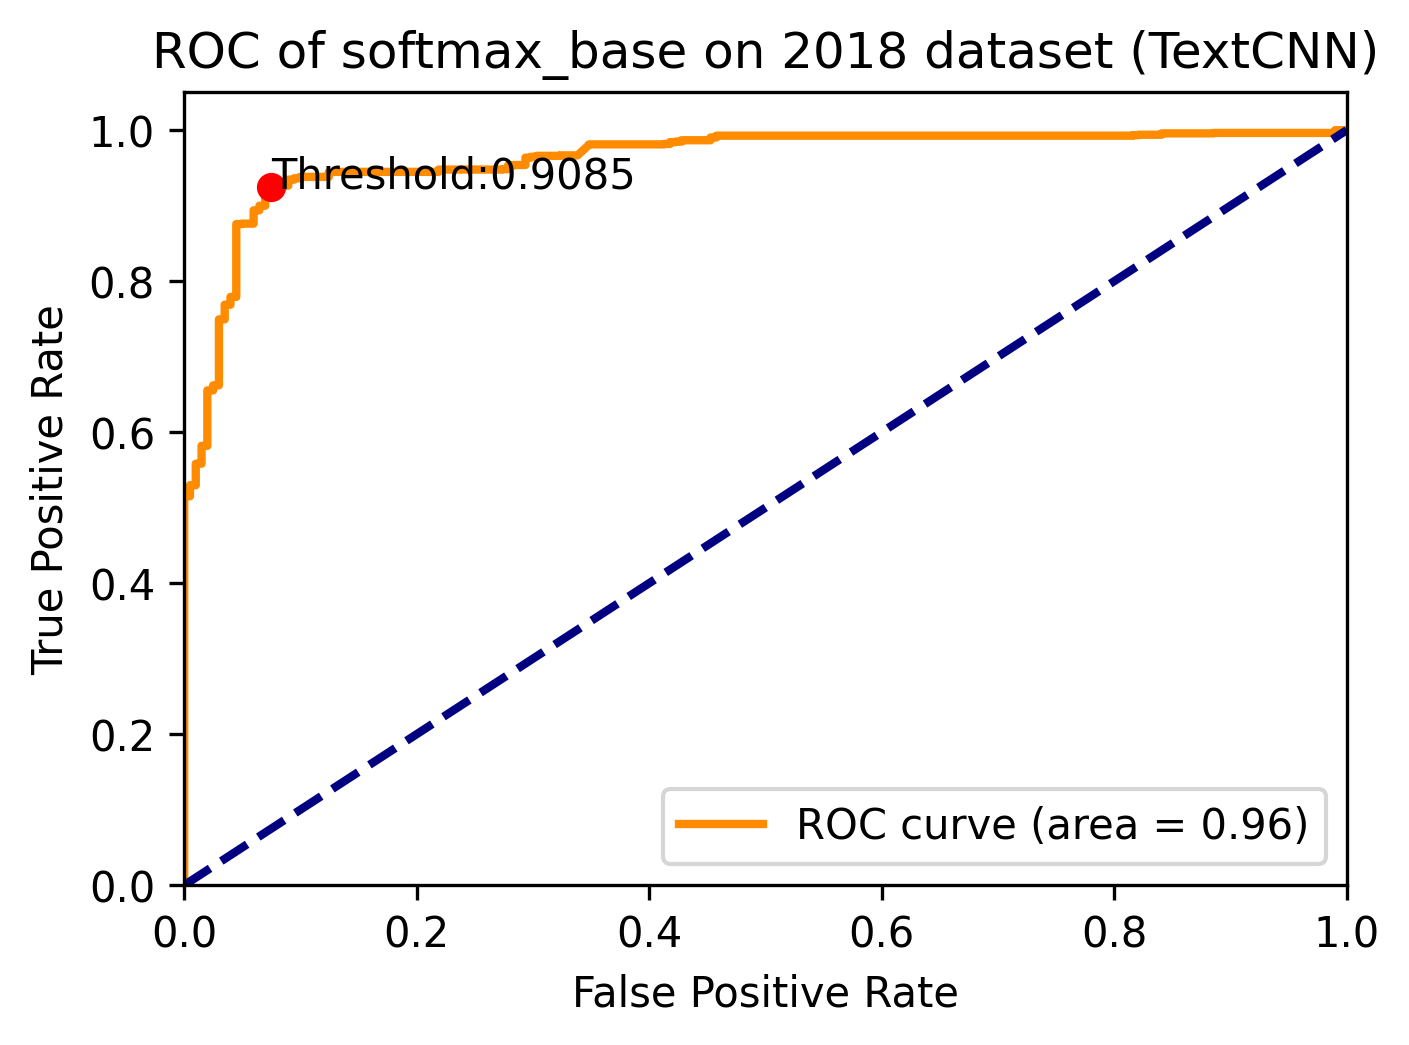

fpr: 0.02368421052631579
score_2:  0.9467329


<Figure size 432x288 with 0 Axes>

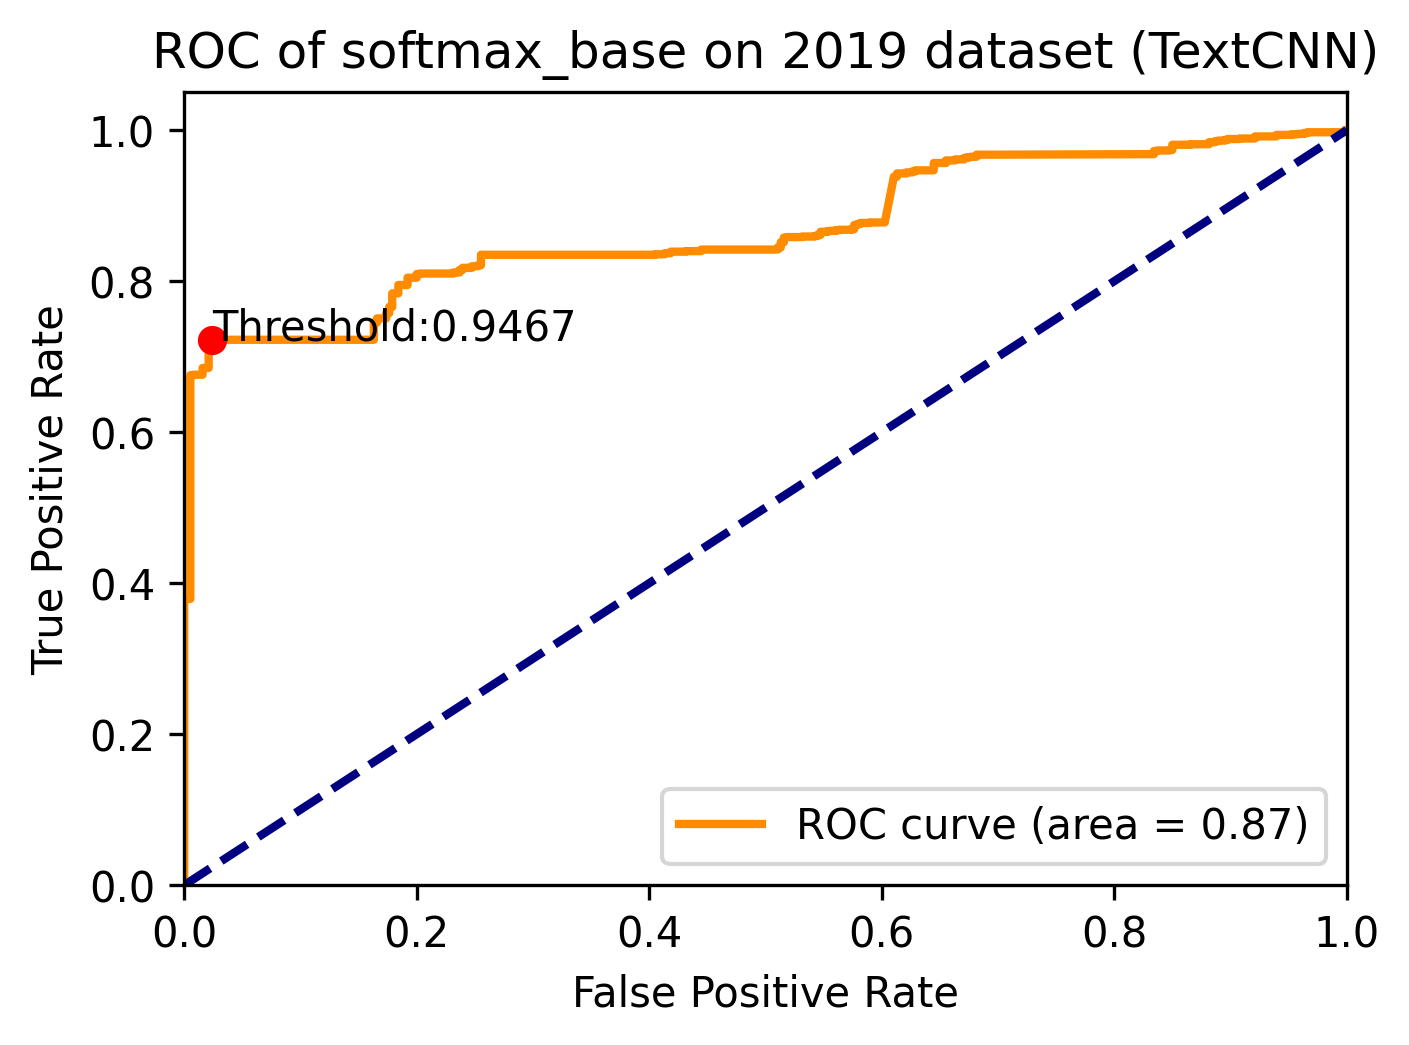

<Figure size 432x288 with 0 Axes>

In [16]:
from sklearn.metrics import roc_curve, auc

# 确定异常检测阈值
fpr, tpr, thresholds = roc_curve(labels_test_1, softmax_1)
roc_auc = auc(fpr, tpr)

# 约登指数确定
index = np.argmax(tpr-fpr)
print(f"fpr: {fpr[index]}")
score_1 = thresholds[index]
print("score_1: ", score_1)

bool_1 = softmax_1 > score_1

# 绘制roc函数曲线
plt.figure(figsize=(5, 3.5),dpi=300)
lw = 2
plt.plot(fpr, tpr, color='darkorange', 
         lw=lw, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.plot(fpr[index], tpr[index], marker='o', color='r')
plt.text(fpr[index], tpr[index], f'Threshold:{score_1:.4f}')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC of softmax_base on 2018 dataset (TextCNN)")
plt.legend(loc="lower right")
plt.show()
plt.savefig("./figures/" + "roc_softmax_1.png")


fpr, tpr, thresholds = roc_curve(labels_test_2, softmax_2)
roc_auc = auc(fpr, tpr)

# 约登指数确定
index = np.argmax(tpr-fpr)
print(f"fpr: {fpr[index]}")
score_2 = thresholds[index]
print("score_2: ", score_2)

bool_2 = softmax_2 > score_2

# 绘制roc函数曲线
plt.figure(figsize=(5, 3.5),dpi=300)
lw = 2
plt.plot(fpr, tpr, color='darkorange', 
         lw=lw, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.plot(fpr[index], tpr[index], marker='o', color='r')
plt.text(fpr[index], tpr[index], f'Threshold:{score_2:.4f}')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC of softmax_base on 2019 dataset (TextCNN)")
plt.legend(loc="lower right")
plt.show()
plt.savefig("./figures/" + "roc_softmax_2.png")

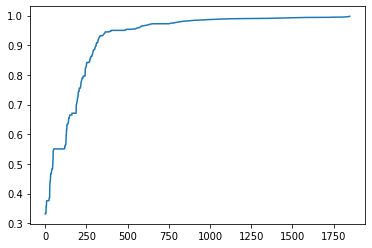

In [17]:
import matplotlib.pyplot as plt

sft_sort = softmax_1
sft_sort.sort()
x = list(range(1849))
plt.figure()
plt.plot(x, sft_sort)

In [18]:
from sklearn.metrics import classification_report

# 测试异常样本剔除后的准确率
name2label = {'trojan':0, 'virus':1, 'worm':2, 'backdoor':3}
labels_pre_id = data_test_1['label'].map(lambda x: name2label[x])
labels_pre_id = np.array(labels_pre_id).reshape(-1, 1)
labels_pre_id = labels_pre_id[bool_1]

model_pre = keras.models.load_model('./model/textcnn_split.h5')
codes_pre_id = code_test_1[bool_1.reshape(-1)]
y_pred = model_pre.predict(codes_pre_id)
y_pred = np.argmax(y_pred, 1)
target_names = {'trojan', 'virus', 'worm', 'backdoor'}
print(classification_report(labels_pre_id, y_pred, target_names=target_names, digits=4))


labels_pre_id = data_test_2['label'].map(lambda x: name2label[x])
labels_pre_id = np.array(labels_pre_id).reshape(-1, 1)
labels_pre_id = labels_pre_id[bool_2]

model_pre = keras.models.load_model('./model/textcnn_split.h5')
codes_pre_id = code_test_2[bool_2.reshape(-1)]
y_pred = model_pre.predict(codes_pre_id)
y_pred = np.argmax(y_pred, 1)
target_names = {'trojan', 'virus', 'worm', 'backdoor'}
print(classification_report(labels_pre_id, y_pred, target_names=target_names, digits=4))

              precision    recall  f1-score   support

        worm     0.9782    0.9960    0.9870       496
    backdoor     0.9943    1.0000    0.9971       519
      trojan     0.9949    0.9949    0.9949       195
       virus     1.0000    0.9628    0.9811       323

    accuracy                         0.9902      1533
   macro avg     0.9918    0.9884    0.9900      1533
weighted avg     0.9904    0.9902    0.9902      1533

              precision    recall  f1-score   support

        worm     0.9835    0.9900    0.9868       301
    backdoor     1.0000    0.9958    0.9979       240
      trojan     0.9798    0.9848    0.9823       197
       virus     1.0000    0.9937    0.9968       316

    accuracy                         0.9915      1054
   macro avg     0.9908    0.9911    0.9909      1054
weighted avg     0.9915    0.9915    0.9915      1054



In [5]:
from utils import *
ood2label = {True: 0, False: 1}
data_test_1 = pd.read_csv('data_test_1.csv')
data_ood = data_test_1[data_test_1['id']==False]
path_ood = data_ood['name'].to_list()
codes_odd = codes_loader(path_ood)

model_random = keras.models.load_model('./model/textcnn_split.h5')
logits_ood = model_random.predict(codes_odd)
soft_ood = keras.backend.softmax(logits_ood)
soft_ood = soft_ood.numpy()
soft_ood = np.max(soft_ood, axis=1)

100%|██████████| 201/201 [00:00<00:00, 214.29it/s]


In [6]:
data_id = data_test_1[data_test_1['id']==True]
path_id = data_id['name'].to_list()
codes_id = codes_loader(path_id)

model_random = keras.models.load_model('./model/textcnn_split.h5')
logits_id = model_random.predict(codes_id)
soft_id = keras.backend.softmax(logits_id)
soft_id = soft_id.numpy()
soft_id = np.max(soft_id, axis=1)

100%|██████████| 1648/1648 [00:10<00:00, 153.46it/s]


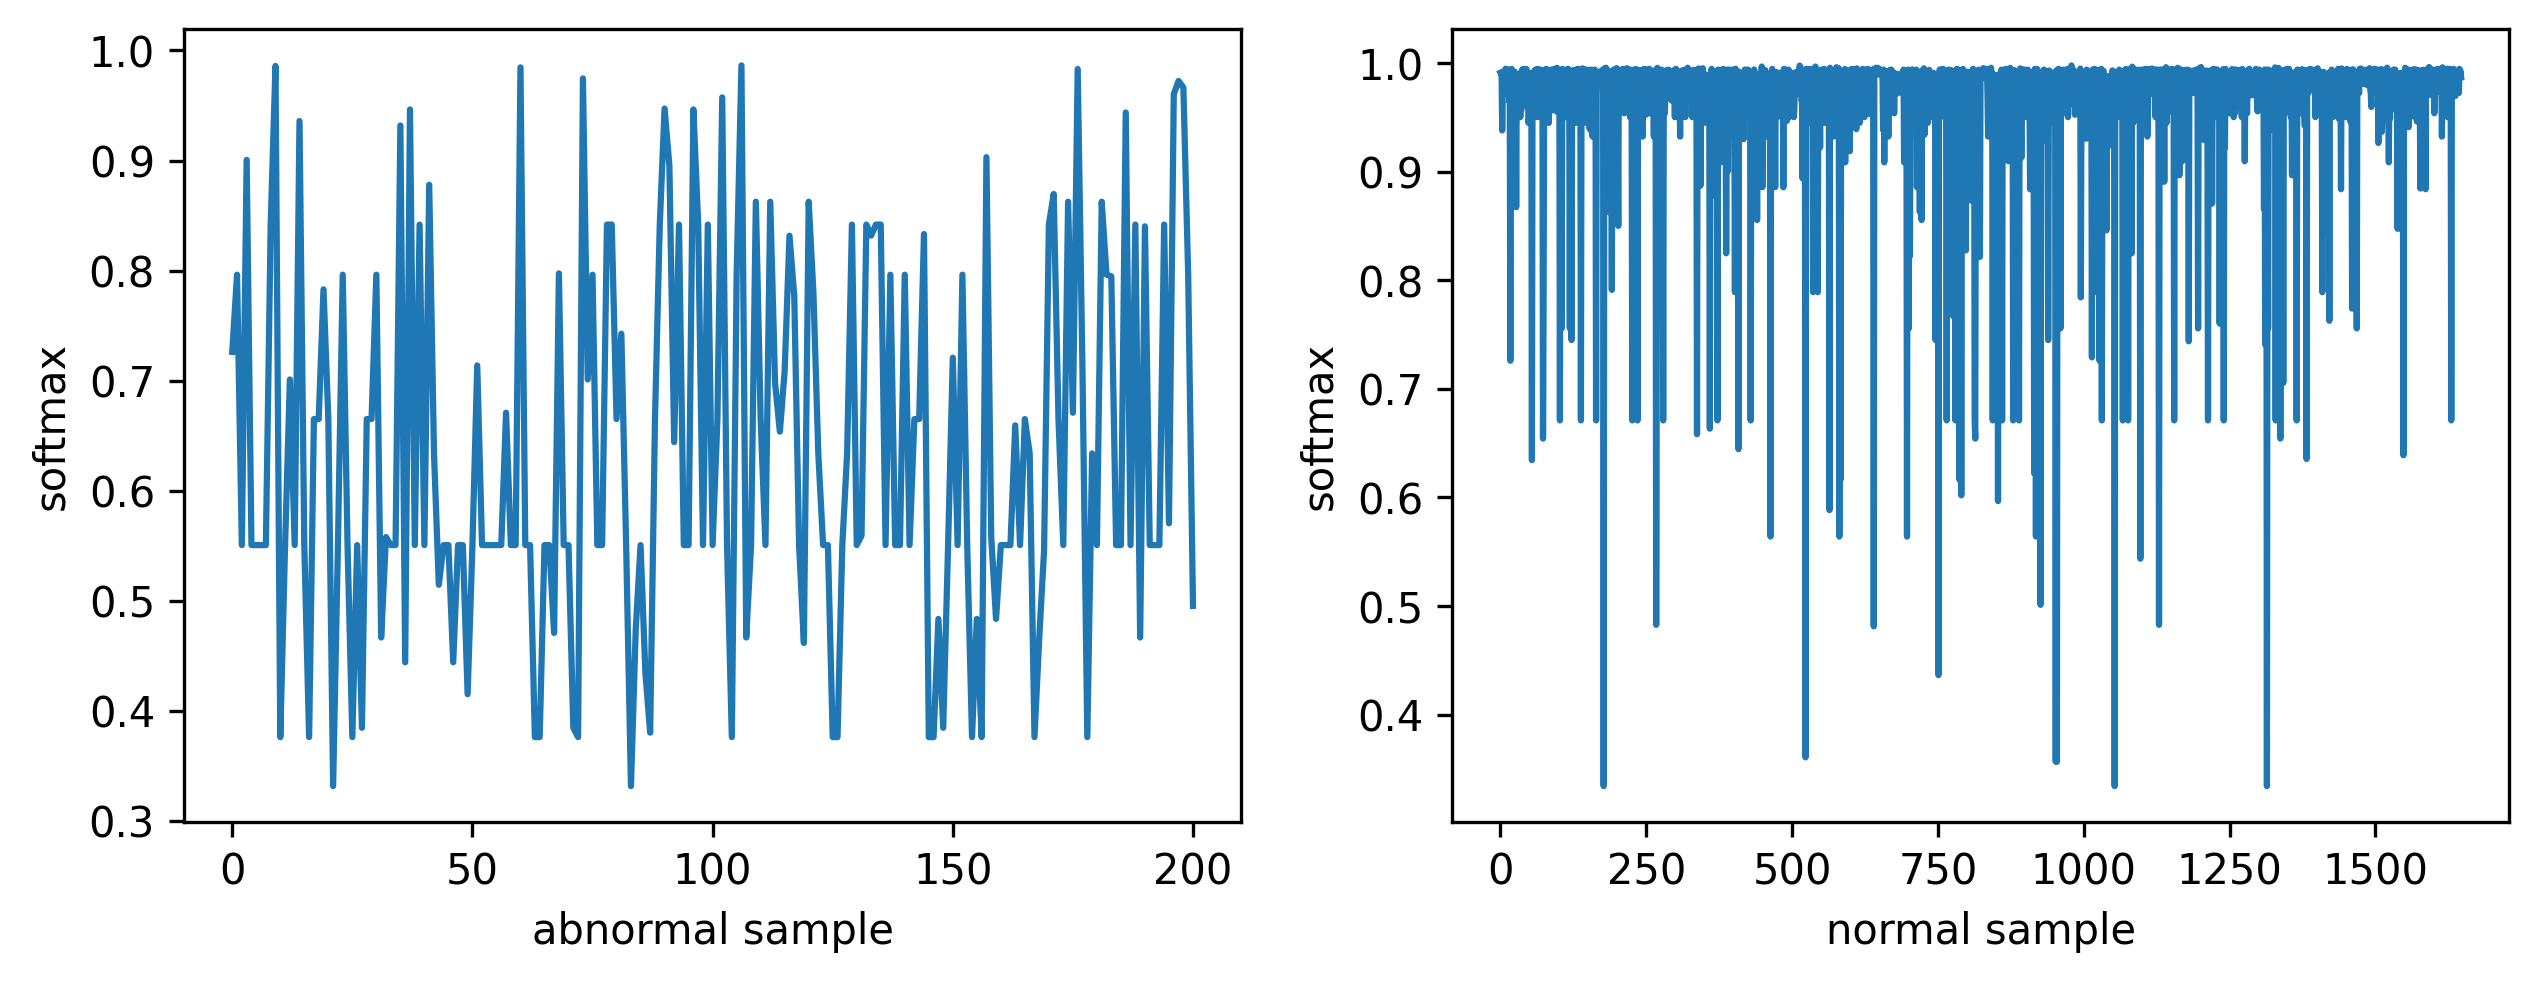

In [9]:
data_id = pd.DataFrame(soft_id, columns=['id'])
data_ood = pd.DataFrame(soft_ood, columns=['id'])

import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(10, 3.5),dpi=300)
ax = fig.add_subplot(121)
sns.lineplot(data=data_ood['id'], ax=ax)
plt.ylabel("softmax")
plt.xlabel("abnormal sample")

ax = fig.add_subplot(122)
sns.lineplot(data=data_id['id'], ax=ax)
plt.ylabel("softmax")
plt.xlabel("normal sample")
plt.savefig("./figures/entropy_analyse.png")

In [10]:
print(np.std(soft_id))
print(np.std(soft_ood))

0.07991362
0.17061251
